# Final Project : Region Based - CNN

### import libraries and dataset

In [1]:
%matplotlib inline
import os
import pandas as pd
import torch
from torch import nn
import torchvision
from d2l import torch as d2l
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

#@save
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

### Reading the dataset

In [2]:
#@save
def read_data_bananas(is_train=True):
    """Read the banana detection dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Here `target` contains (class, upper-left x, upper-left y,
        # lower-right x, lower-right y), where all the images have the same
        # banana class (index 0)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [3]:
#@save
class BananasDataset(torch.utils.data.Dataset):
    """A customized dataset to load the banana detection dataset."""
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [4]:
#@save
def load_data_bananas(batch_size):
    """Load the banana detection dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return train_iter, val_iter

In [5]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

### example 

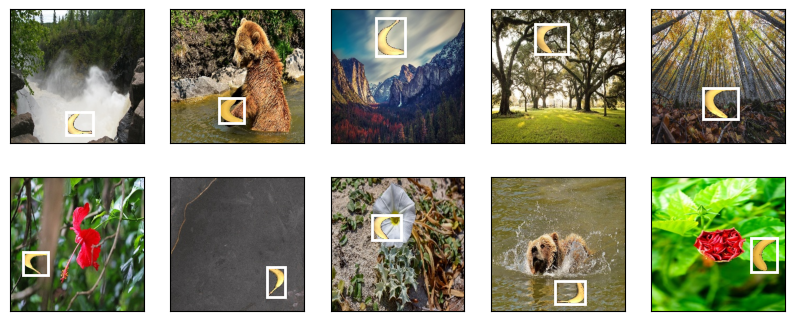

In [6]:
imgs = (batch[0][:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

### definition of the faster r-cnn

In [7]:
class FastRCNN(nn.Module):
    def __init__(self, num_classes, roi_size):
        super(FastRCNN, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.roi_pooling = ops.RoIPool(output_size=roi_size, spatial_scale=1.0)
        self.fc1 = nn.Linear(2048 * roi_size * roi_size, 1024)
        self.fc2_cls = nn.Linear(1024, num_classes)
        self.fc2_bbox = nn.Linear(1024, 4)  # 4 pour les coordonnées (x, y, w, h)

    def forward(self, x, rois):
        # Passer l'image entière par le backbone CNN
        features = self.backbone(x)

        # Appliquer RoI pooling sur les régions d'intérêt (region proposals)
        pooled_features = self.roi_pooling(features, rois)

        # Aplatir les caractéristiques pour les passer à travers les couches entièrement connectées
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        pooled_features = nn.functional.relu(self.fc1(pooled_features))

        # Prédiction de classe
        class_scores = self.fc2_cls(pooled_features)

        # Prédiction de la boîte englobante (bounding box)
        bbox_preds = self.fc2_bbox(pooled_features)

        return class_scores, bbox_preds

### prepare dataset

In [8]:
batch_size = 4  # Choisissez la taille de batch appropriée
train_loader, val_loader = load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


### train model

In [9]:
def train_model(model, train_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0.0
        for images, targets in train_loader:
            optimizer.zero_grad()
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            # Calculer la somme totale des pertes
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Rétropropagation
            losses.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")



### define hyperparameters

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_classes=2)  # 2 classes: fond et banane
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 10

train_model(model, train_loader, optimizer, num_epochs)


NameError: name 'get_model' is not defined

In [11]:
device

device(type='cpu')